In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline

In [2]:
def read_imag_values(file):
    result = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for index, row in enumerate(reader):
            result.append([float(element) for element in row])
    return(result)

In [14]:
def transform_to_density(b_values, Ic_values, y_values):
    phi0 = 2.067e-15 #in T*m**2
    W = 1.771e-8 # in m, scaled system size
    L = 4.92e-9 # in m, scaled system size
    omega = 2 * np.pi * L
 
    phi_values = b_values * W * L * phi0
    dPhi = phi_values[1] - phi_values[0]

    real, imag = Ic_values
    
    Jy_values = []
    for y in y_values:
        Jy_real = 0
        Jy_imag = 0
        for k, phi in enumerate(phi_values):
            Ic_real = real[k] #Fourier coefficient
            Ic_imag = imag[k]
            Jy_real += (Ic_real * np.cos(omega * phi * y) - Ic_imag * np.sin(omega * phi * y)) * dPhi
            Jy_imag += (Ic_imag * np.cos(omega * phi * y) + Ic_real * np.sin(omega * phi * y)) * dPhi
        #Jy_abs = np.sqrt(Jy_real**2 + Jy_imag**2)
        Jy_values.append((Jy_real, Jy_imag))
    return(Jy_values)

In [15]:
datafile = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=0.0-20171025-15:47:01/data.csv'

In [34]:
values = np.asarray(read_imag_values(datafile)).T
absval , realval, imagval = values
maxB = 1e-04
magnetic_field = np.linspace(-maxB, maxB, 1000)


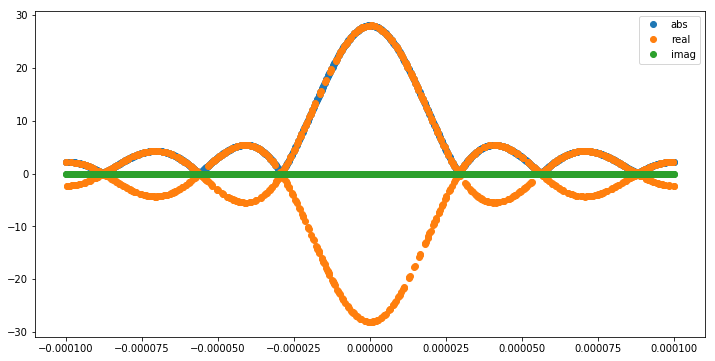

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
for index, labelname in enumerate(['abs', 'real', 'imag']):
    ax.plot(magnetic_field, values[index], label=labelname, linestyle='none', marker='o')
ax.legend()

In [38]:
W = 1.771e-8
y = np.linspace(-W, W, 500)
density = transform_to_density(magnetic_field, (realval, imagval), y)
dens_real, dens_imag = zip(*density)

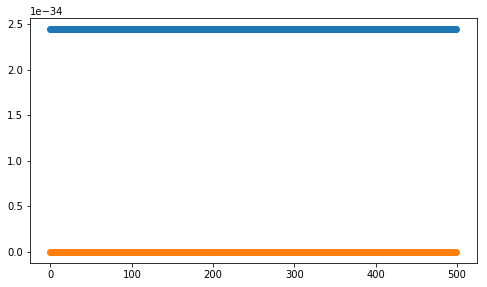

In [39]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(dens_real, marker='o')
ax.plot(dens_imag, marker='o')

In [22]:
file2 = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=-0.4-20171026-13:46:14/data.csv'
values = np.asarray(read_imag_values(file2)).T

density2 = transform_to_density(magnetic_field, (values[0], values[1]), y)

In [23]:
dens2_real, dens2_imag = zip(*density2)

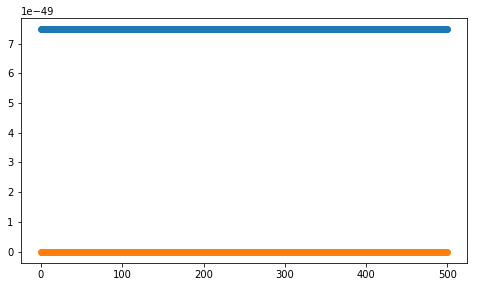

In [24]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(dens_real, marker='o')
ax.plot(dens_imag, marker='o')